# ВОРКШОП от компании Samokat.tech

## Описание проекта

    Задача от Яндекс.Практикум и Samokat.tech – реализовать векторный поиск и решить усечённую задачу матчинга.
    
    Про векторный поиск
    Векторный поиск - поиск ближайших N товаров из коллекции base для каждого товара из query.
    На многомиллионных данных полезно использовать зарекомендовавшие себя реализации векторного поиска. Одной из таких реализаций является FAISS.
    
    Про матчинг
    Конечная цель матчинга заключается в определении, являются ли два или более предмета эквивалентными или одним и тем же объектом. 
    В контексте задачи матчинга в базе данных (base) хранится информация о продуктах, которые могут быть предложены для покупки. Запрос (query) представляет из себя набор конкретных продуктов, для которых необходимо найти соответствие в базе данных. 
    
    Задача состоит в том, чтобы автоматически сопоставить запрос с подходящим элементом из базы данных и предоставить пользователю наиболее релевантный результат. Это позволяет снизить дублирование товаров и упростить процесс управления продуктами, что способствует увеличению эффективности и экономии времени.

### Цель

Разработка решения поиска в базе 10 образцов с максимальным соответствием

### Задачи

- изучить данные
- подготовить решение
- принять участие в соревновании на [платформе Kaggle](https://www.kaggle.com/competitions/samokattechworkshop)
- передать заказчику оформленное решение в виде [репозитория на GitHub](https://github.com/artefucktor/samokat_workshop)

### Данные

- base.csv словарь с векторами товаров
- train.csv тренировочная выборка с правильным соответствием запроса и ответа из словаря
- test.csv тестовая выборка, для которой надо найти соответствие
- answer_sample.csv образец предсказаний, необходимо для каждого запроса предоставить 10 ответов, объединенных в строку

---



## Практическая часть

### Изучение признаков

- Были построены и протестированы индивидуальные индексы для каждого признака в отдельности.
- Соединены base и train по соответствию таргета индексу базы и проверена корреляция всех признаков между этими выборками.
- Построены гистограммы всех признаков.

### Особенности

В целом все корреляции примерно на одном уровне, большинство признаков имеют нормальное распределение.
- единичный нормальный признак дает recall примерно 0.010-0.011

Выявлены странные признаки – у них ненормальное распределение и низкая корреляция между соответствующими образцами в базе и в учебной выборке.
- признаки 33 и 59 дали вообще нулевой recall
- признаки 21, 25, 33, 44 очень низкий результат примерно 0.003-0.008
- признак 65 на индивидуальном тестировании дает recall 0.011 на уровне среднего, но имеет слабую корреляцию
- признаки 6 и 70 на первый взгляд похожи на плохие, они имеют ненормальное распределение, сниженный коэффициент корреляции, но при индивидуальном тестировании у них внезапно высокий recall – 0.013 у шестого и особенно 0.028 у семидесятого признака, то есть более чем вдвое выше остальных! Это очень важный признак, и его особенность надо использовать! Но как?

Графическое представление выявленных особенностей очень громоздкое и вынесено за пределы тетрадки, файлы с картинками доступны отдельно в [репозитории](https://github.com/artefucktor/samokat_workshop) и по прямым ссылкам:
- Гистограммы распределения признаков https://github.com/artefucktor/samokat_workshop/histogram.png
- Recall для каждого признака при индивидуальном тестировании https://github.com/artefucktor/samokat_workshop/single_recall.png
- Корреляции между признаками в train и base https://github.com/artefucktor/samokat_workshop/corr_heatmap.png

### Решение

#### Индекс
Для улучшения качества поиска:
- из индекса исключены признаки 21, 25, 33, 44, 59, 65
- проведено масштабирование с помощью StandardScaler

Были протестированы различные комбинации признаков.
- Поиск по основным признакам дает recall 0.60 на обучающей выборке
- Поиск по выделенным признакам 6 и 70 дает recall 0.28
- На обучающей выборке:
    - результаты основного и дополнительного индекса отличаются в 80% случаев
    - почти 9% случаев, когда предсказания не совпали и прав именно дополнительный индекс

Это можно использовать для повышения общего скора, но надо научиться определять когда основной поиск является ошибочным, и с какой вероятностью именно дополнительный результат является верным.

#### Классификация
В процессе многочисленных экспериментов выявлено что основой для классификации может быть отдельная мини выборка
- предсказание по индексу faiss построенному из двух признаков 6 и 70
- сходство (или его отсутствие?) cosine similarity между предсказанными ответами основного и дополнительного индекса
- комбинация странных признаков 6, 70 и отбракованных 33, 44

Далее необходимо решить задачу классификации для ответа на вопросы – поиск по какому индексу является верным и как избежать потери правильных ответов? Будем руководствоваться такой логикой – если предсказания совпали, то классификация не имеет значения, если не совпали, тогда опираемся на решение классификатора.

В целевую переменную поместим условие – верным ответом является дополнительный.
На основе этих данных построена и протестирована модель XGBClassifier. Для более точной работы добавлен гиперпараметр scale_pos_weight для дисбаланса классов. Скорректирован порог threshold – консервативный 0.60 дает оптимальный результат.

Соответственно, выполняем два поиска – по основному индексу с нормальными признаками и по дополнительному с признаками 6 и 70. Выполняем классификацию, при положительном ответе классификатора верным предсказанием считаем дополнительное и корректируем итоговый submission.

### Какие подходы не сработали

- Пересортировка полученных ответов по distance, перерасчет расстояний, косинусных, евклидовых...
- Использование других инструментов для мэтчинга, sentence_transformers.util.semantic_search, annoy, sklearn.metrics.pairwise.cosine_similarity, scipy.spatial.distance...
- Оптимизация faiss, normalizer, кластеризация, метод главных компонент...

В условиях ограниченного ресурса пришлось отказаться от громоздких экспериментов, медленных или излишне замороченных реализаций, которые приносят микроскопический результат, неадекватный затраченным усилиям.

А еще не хватило терпения оптимизировать код и сократить его дублирование вдвое, потому что уже и так хорошо. Работает – не трогай :)

---

## Заключение
### Выводы

Модуль faiss – топчик!

Вижу потенциал в улучшении классификации. Альтернативный индекс может добавить 8-9% верных ответов, не найденных основным индексом. На данный момент, манипулируя порогом классификации, удалось получить прирост всего 2-3% к среднему уровню 74-75% верных ответов.

Возможно, признаки 6 и 70 являются не товарами, а категориями? В любом случае, на мой взгляд для улучшения поиска имеет смысл попробовать выявить триггеры, которые позволят быстро переключаться с одного индекса на другой более релевантный.

### Результат

На ЛБ получен скор 0.77447 на паблике и 0.77120 на привате, то есть сейчас такой комбинированный подход позволяет найти 77% верных ответов.

Ссылка на воркшоп на платформе kaggle https://www.kaggle.com/competitions/samokattechworkshop

---


In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sentence_transformers import util

import faiss
import xgboost


In [2]:
DATA_DIR = "samokattechworkshop/"

In [3]:
base = pd.read_csv(f"{DATA_DIR}base.csv", index_col="Id")
train = pd.read_csv(f"{DATA_DIR}train.csv", index_col="Id")
test = pd.read_csv(f"{DATA_DIR}test.csv", index_col="Id")

In [4]:
def faiss_search(index, df, pre, num):
    """Поиск в индексе
    
    Принимает:
    index -- faiss индекс
    df -- выборка для поиска
    pre -- препроцессинг
    num -- сколько образцов надо получить

    Возвращает объединенную строку с образцами 
    """
    global base
    D, I = index.search(pre.transform(df), num)
    preds = pd.DataFrame(I, index=df.index)
    for col in preds:
        preds[col] = base.iloc[preds[col].values].index.to_list()
    return preds.agg(" ".join, axis=1)

In [5]:
def similarity(df):
    """Косинусное сходство основного и дополнительного предсказаний

    Принимает подвыборку с колонками preds_main и preds_670
    Рассчитывает среднее cosine similarity для каждого набора

    Возвращает список float
    """
    global base
    cos_sim = []
    for row in df.iterrows():
        preds_main_split = row[1].preds_main.split()
        preds_670_split = row[1].preds_670.split()
        cos_sim_mean = []
        for i in range(len(preds_main_split)):
            cos_sim_mean.append(
                util.cos_sim(
                    base.loc[preds_main_split[i]], base.loc[preds_670_split[i]]
                )
            )
        cos_sim.append(np.mean([float(i[0][0]) for i in cos_sim_mean]))
    return cos_sim

In [6]:
# обозначим колонки для работы, целевой признак
# соберем комплекты данных основной и дополнительный

to_drop = ["21", "25", "33", "44", "59", "65"]    # базовый прирост метрики обеспечен удалением этих признаков

# чтобы не было путаницы где дропаем, а где выбираем, приводим список колонок к единому виду – только выбираем :)
include_main = [col for col in base.columns if col not in to_drop]
include_670 = ["6", "70"]
preds_name = ["preds_main", "preds_670"]

base_main = base[include_main]
base_670 = base[include_670]

train_main = train[include_main]
train_670 = train[include_670]

target = train.Target

test_main = test[include_main]
test_670 = test[include_670]

In [7]:
# подготовим пайплайны для предобработки
# здесь были разные эксперименты, но осталось только стандартное масштабирование

pipe_main = Pipeline([
    ('scale', StandardScaler())    # масштабирование прибавляет пару процентов
])

pipe_670 = Pipeline([
    ('scale', StandardScaler())
])


In [8]:
# подготовим основной и дополнительный индекс faiss
base_main_scaled = pipe_main.fit_transform(base_main)
index_main = faiss.IndexFlatL2(base_main_scaled.shape[1])
index_main.add(base_main_scaled)

base_670_scaled = pipe_670.fit_transform(base_670)
index_670 = faiss.IndexFlatL2(base_670_scaled.shape[1])
index_670.add(base_670_scaled)

In [9]:
# выбираем из индексов предсказания – по основному и дополнительному
# объединяем их в датафрейм и добавим колонки для обучения классификатора
# выведем какую долю правильных образцов удалось найти
preds = pd.DataFrame({
    "preds_main": faiss_search(index_main, train_main, pipe_main, 1),
    "preds_670": faiss_search(index_670, train_670, pipe_670, 1)
    })

preds[["6", "33", "44", "70"]] = train[["6", "33", "44", "70"]]
preds["cos_sim"] = similarity(preds[preds_name])
preds["real_target"] = target

# preds["maybe"] = ((preds.preds_670 != preds.preds_main) & (preds.preds_670 == preds.real_target)).astype('int')
preds["maybe"] = (preds.preds_670 == preds.real_target).astype('int')
(preds["real_target"]==preds["preds_main"]).sum()/preds.shape[0]

0.60209

In [10]:
# подготовим список признаков для модели и колонку таргета
# посчитаем scale_pos_weight – полезно для xgboost при дисбалансе классов
to_ml = ["6", "33", "44", "70", "cos_sim"]
ml_target = "maybe"
scale_pos_weight = preds.shape[0]/preds["maybe"].sum() # это добавило несколько тысячных на ЛБ
scale_pos_weight


3.4965034965034967

In [11]:
%time
# посмотрим на кросс-валидацию с метрикой recall
gbc = xgboost.XGBClassifier(random_state=7, scale_pos_weight=scale_pos_weight)
cross_val_score(gbc, 
                preds[to_ml], 
                y=preds[ml_target], 
                scoring="roc_auc", 
                n_jobs=-1, 
                cv=3)


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.29 µs


array([0.97871867, 0.97899998, 0.97906181])

In [12]:
# обучим классификатор на полном трейне и посмотрим на важность признаков
gbc.fit(preds[to_ml], y=preds[ml_target])
pd.Series(gbc.feature_importances_, index=to_ml).sort_values(ascending=False)

cos_sim    0.568633
33         0.230233
70         0.098411
6          0.067634
44         0.035089
dtype: float32

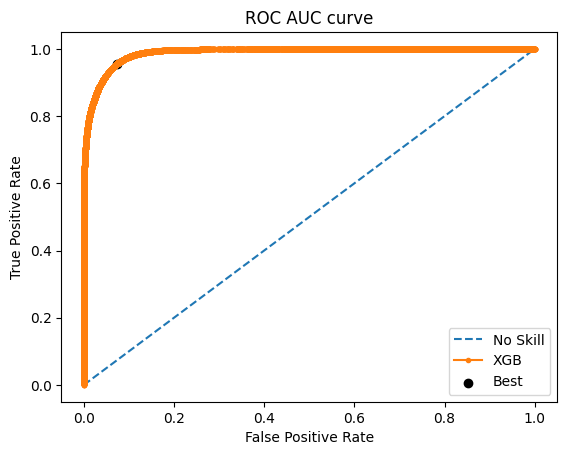

0.60239595


In [20]:
# посмотрим на roc кривую и уточним оптимальный порог
fpr, tpr, thresholds = roc_curve(
    preds[ml_target],
    gbc.predict_proba(preds[to_ml])[:, 1]
    # cross_val_predict(gbc, preds[to_ml], y=preds[ml_target], n_jobs=-1, cv=3, method='predict_proba')[:, 1]
    )
# консервативный порог 0.60 с полного трейна дает лучший итоговый результат, 
# чем излишне оптимистичный 0.46 на кросс-валидации
# форма графика на cv не особо отличается, малость покруглее
# рабочий вариант cross_val_predict закомментирован, при желании можно включить его
# вижу пространство для экспериментов с коррекцией порога вручную

J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

plt.plot([0, 1], [0, 1], linestyle="--", label="No Skill")
plt.plot(fpr, tpr, marker=".", label="XGB")
plt.title('ROC AUC curve')
plt.scatter(fpr[ix], tpr[ix], marker="o", color="black", label="Best")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(best_thresh)

In [14]:
try:
    os.system('say model training completed');
except:
    pass

In [15]:
# готовим submission
# выполняем поиск по индексу – основные признаки и дополнительные
# объединяем предсказания в датафрейм
# проверяем классификатором, какие ответы можно скорректировать
# в найденных случаях заменяем основной ответ на дополнительный
subs = pd.DataFrame({
    "preds_main": faiss_search(index_main, test_main, pipe_main, 10), 
    "preds_670": faiss_search(index_670, test_670, pipe_670, 10)
})

subs[["6", "33", "44", "70"]] = test[["6", "33", "44", "70"]]
subs["cos_sim"] = similarity(subs[preds_name])
subs["gbc_check"] = gbc.predict_proba(subs[to_ml])[:, 1] > best_thresh

subs["Predicted"] = subs.preds_main
subs.loc[subs.gbc_check, "Predicted"] = subs.preds_670 
# замена потенциально неверных ответов на дополнительные добавила еще пару процентов 

In [16]:
# выводим файл с результатами
subs["Predicted"].to_csv("submission.csv", index="Id")
try:
    os.system('say predictions ready to submit');
except:
    pass
